In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter

# For coord projections
import pyproj

# For plotting (maps)
# import pygmt
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt

# for mesh, forward modeling and inversion
from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz
from simpeg.utils import plot2Ddata, model_builder
from simpeg import maps
from simpeg.potential_fields import gravity
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
import choclo

from gravity_inversion_functions import create_gravity_mesh, create_density_model


### Import data set from netCDF file from processing notebook

In [17]:
grav_data = xr.open_dataarray('./gravity_residual_kolumbo.nc')
bathy_data = xr.open_dataarray('./bathymetry_refellips.nc')
meas_height = xr.open_dataarray('./measurement_heights_grav.nc')

In [15]:
grav_east, grav_north = np.meshgrid(grav_data.easting.values, grav_data.northing.values)
bathy_east, bathy_north = np.meshgrid(bathy_data.easting.values, bathy_data.northing.values)
xyz_topo = np.c_[mkvc(bathy_east), mkvc(bathy_north), mkvc(bathy_data.values)]

## Synthetic Data Inversion

### Define a Tree Mesh

In [3]:
# define the cell widths in m
dx = dy = dz = 500
# define the padding outside the zone with small cells in m
pad_x = pad_y = 11000
#define the depth of the mesh
z_length = 22000.0 

mesh = create_gravity_mesh(
    dx=dx,
    dy=dy,
    dz=dz,
    grav_east=grav_data.easting,
    grav_north=grav_data.northing,
    pad_x=pad_x,
    pad_y=pad_y,
    z_length=z_length
)

/Users/kmaetschke/PhD/Classes/EOSC 556B/course project/gravity_inversion_functions.py:76: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  mesh = TreeMesh([hx, hy, hz], x0=[mesh_min_x, mesh_min_y, -z_length])


### Create a synthetic 'true' model

In [64]:
# Create model with sphere
true_model, ind_active, model_map = create_density_model(
    mesh=mesh,
    xyz_topo=xyz_topo,
    background_density=0.0,
    include_sphere=True,
    sphere_density=-0.3,
    sphere_depth=-3000.0,
    sphere_radius=1500.0
)

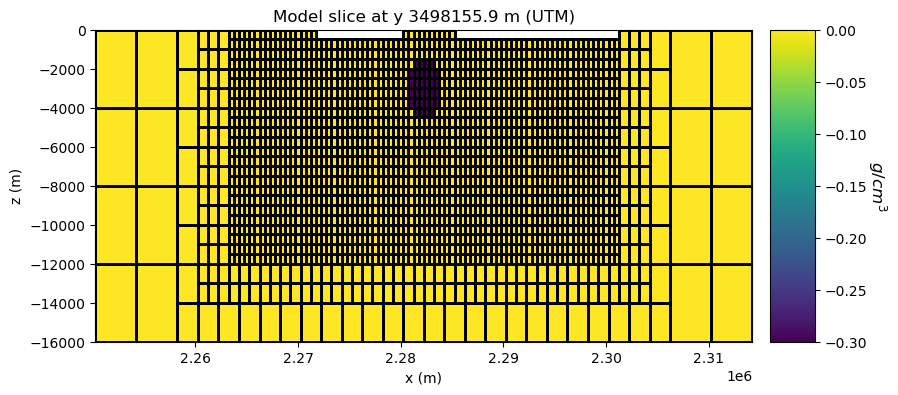

In [ ]:
#define the center of the mesh
center_meas_x = (np.min(mesh.cell_centers_x) + np.max(mesh.cell_centers_x)) / 2.0
center_meas_y = (np.min(mesh.cell_centers_y) + np.max(mesh.cell_centers_y)) / 2.0

#plot the true model
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plot_slice(
    plotting_map * true_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.h[1].size / 2),
    grid=True,
    clim=(np.min(true_model), np.max(true_model)),
    pcolor_opts={"cmap": "viridis"},
)
ax1.set_title(f"Model slice at y {center_meas_y:.1f} m Northing")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(true_model), vmax=np.max(true_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()

### Forward calculation based on synthetic model

In [67]:
receiver_locations = np.c_[mkvc(grav_east), mkvc(grav_north), mkvc(meas_height.values)]

# Define the component(s) of the field to simulate
components = ["gx", "gy", "gz"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = gravity.receivers.Point(receiver_locations, components=components)

receiver_list = [receiver_list]

# Defining the source field.
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Defining the survey
survey = gravity.survey.Survey(source_field)

In [68]:
#defining the physics of the gravity problem
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    rhoMap=model_map,
    active_cells=ind_active,
    store_sensitivities="forward_only",
    engine="choclo" 
)

In [ ]:
#defining the synthetic 'observed' data, from the forward modeling of the synthetic model
dobs_syn = simulation.dpred(true_model)
n_data = len(dobs_syn)

# assigning uncertainties
maximum_anomaly = np.max(np.abs(dobs_syn))
uncertainties = 0.01 * maximum_anomaly * np.ones(np.shape(dobs_syn))

#adding noise
noise_level = 0.015 * maximum_anomaly * np.ones(np.shape(dobs_syn))
np.random.seed(42)  # for reproductibility
noise = np.random.normal(0, noise_level, size=n_data)
dobs_syn = dobs_syn + noise

# define the data object that is later inverted
data_object = data.Data(survey, dobs=dobs_syn, standard_deviation=uncertainties)

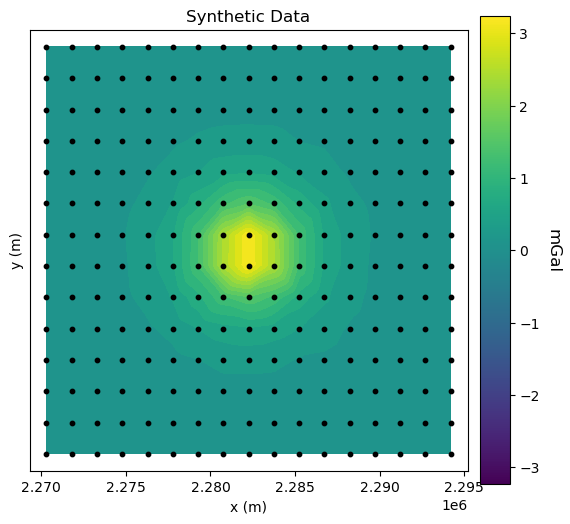

In [77]:
# plot the 
fig = plt.figure(figsize=(6, 6))
n_locations = receiver_locations.shape[0]
v_max = np.max(np.abs(dobs_syn))

ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
cplot3 = plot2Ddata(
    receiver_locations,
    dobs_syn[2:n_data:3],
    ax=ax1,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "viridis"},
)
cplot3[0].set_clim((-v_max, v_max))
ax1.scatter(
    receiver_locations[:, 0],
    receiver_locations[:, 1],
    c="k",
    s=10,
    zorder=3,
)
x_range = ax1.get_xlim()
ax1.set_xlim(x_range[0] - 1000, x_range[1] + 1000)
y_range = ax1.get_ylim()
ax1.set_ylim(y_range[0] - 1000, y_range[1] + 1000)
ax1.set_title("Synthetic Data")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")
ax1.set_yticks([])

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap='viridis'
)
cbar.set_label("mGal", rotation=270, labelpad=15, size=12)

plt.show()

### Inversion with synthetic data

In [78]:
# Find the indices of the active cells in forward model (ones below surface)
ind_active = active_from_xyz(mesh, xyz_topo)

# Define mapping from model to active cells
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model consists of a value for each active cell

# Define and plot starting model
starting_model = np.zeros(nC)

In [79]:
# Define the data misfit.  I'm doing a L2 inversion 
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)

# Define the regularization (model objective function).
reg = regularization.WeightedLeastSquares(
    mesh, active_cells=ind_active, mapping=model_map
)

# Define how the optimization problem is solved (projected
# Gauss-Newton approach that employs the conjugate gradient solver)
opt = optimization.ProjectedGNCG(
    maxIter=10, lower=-1.0, upper=1.0, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [80]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Defining the fractional decrease in beta and the number of Gauss-Newton solves
# for each beta value.
beta_schedule = directives.BetaSchedule(coolingFactor=5, coolingRate=1)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)

# The directives are defined as a list.
directives_list = [
    sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    update_jacobi,
    target_misfit,
]

In [81]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.23.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    


/Users/kmaetschke/PhD/.conda/lib/python3.12/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.77e-01  1.31e+05  0.00e+00  1.31e+05    3.83e+02      0              
   1  3.54e-02  8.63e+04  9.63e+04  8.97e+04    3.82e+02      0              
   2  7.09e-03  4.67e+04  6.55e+05  5.13e+04    3.79e+02      0   Skip BFGS  
   3  1.42e-03  1.52e+04  2.69e+06  1.91e+04    3.67e+02      0   Skip BFGS  
   4  2.84e-04  2.78e+03  6.32e+06  4.57e+03    3.38e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.3055e+04
0 : |xc-x_last| = 1.7081e-01 <= tolX*(1+|x0|) = 1.0000e-01
0 : |proj(x-g)-x|    = 3.3806e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 3.3806e+02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      10    <= iter

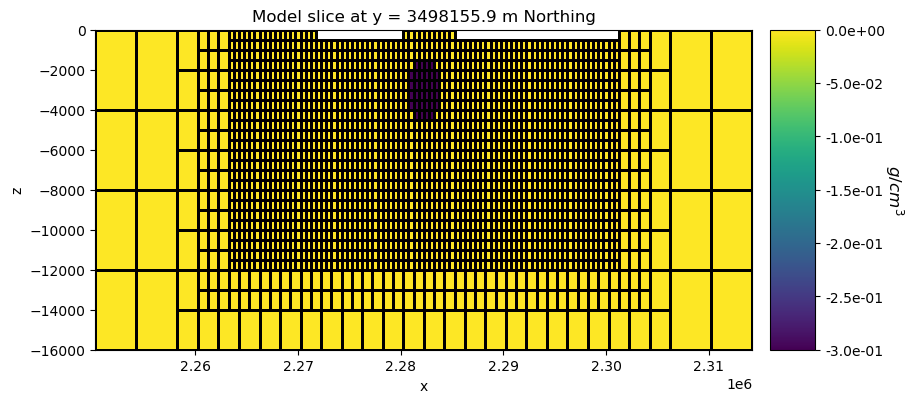

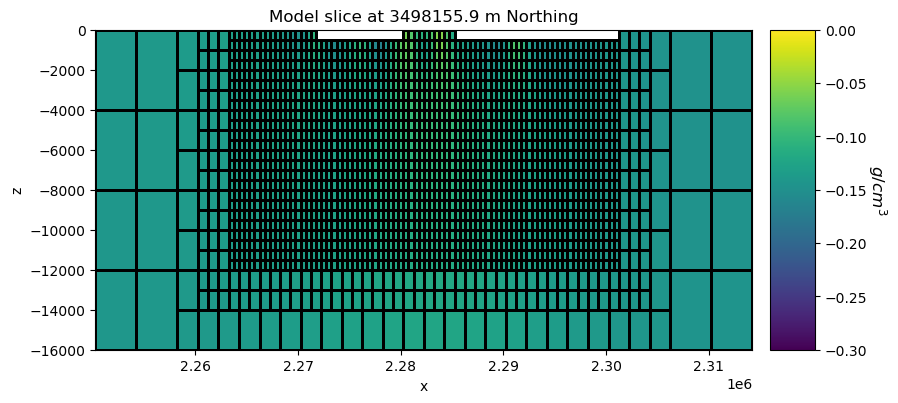

In [104]:
# Plot True Model
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
mesh.plot_slice(
    plotting_map * true_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=True,
    clim=(np.min(true_model), np.max(true_model)),
    pcolor_opts={"cmap": "viridis"},
)
ax1.set_title(f"Model slice at y = {center_meas_y:.1f} m Northing")


ax2 = fig.add_axes([0.85, 0.1, 0.05, 0.8])
norm = mpl.colors.Normalize(vmin=np.min(true_model), vmax=np.max(true_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis, format="%.1e"
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()

# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
mesh.plot_slice(
    plotting_map * recovered_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=True,
    clim=(np.min(recovered_model), np.max(recovered_model)),
    pcolor_opts={"cmap": "viridis"},
)
ax1.set_title(f"Model slice at {center_meas_y:.1f} m Northing")

ax2 = fig.add_axes([0.85, 0.1, 0.05, 0.8])
norm = mpl.colors.Normalize(vmin=np.min(true_model), vmax=np.max(true_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()

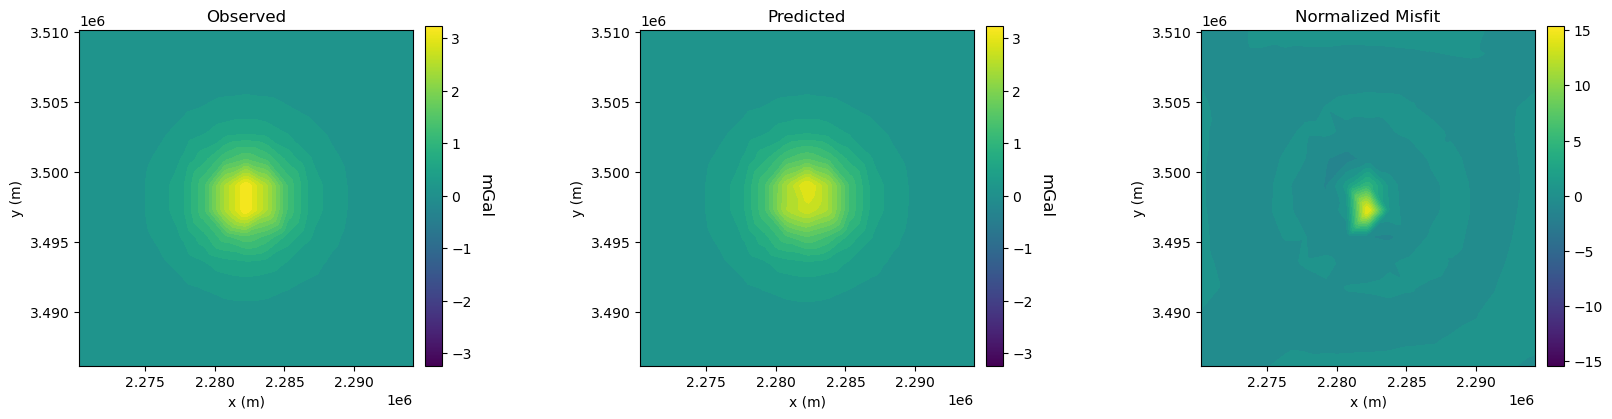

In [ ]:
# Predicted data with final recovered model
dpred = inv_prob.dpred

# Observed data | Predicted data | Normalized data misfit
data_array = np.c_[dobs_syn, dpred, (dobs_syn - dpred) / uncertainties]

fig = plt.figure(figsize=(17, 4))
plot_title = ["Observed", "Predicted", "Normalized Misfit"]
plot_units = ["mGal", "mGal", ""]

ax1 = 3 * [None]
ax2 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]
v_lim = [np.max(np.abs(dobs_syn)), np.max(np.abs(dobs_syn)), np.max(np.abs(data_array[:, 2]))]


for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.33 * ii + 0.03, 0.11, 0.23, 0.84])
    cplot[ii] = plot2Ddata(
        receiver_list[0].locations,
        data_array[2:n_data:3, ii],
        ax=ax1[ii],
        ncontour=30,
        clim=(-v_lim[ii], v_lim[ii]),
        contourOpts={"cmap": "viridis"},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("x (m)")
    ax1[ii].set_ylabel("y (m)")

    ax2[ii] = fig.add_axes([0.33 * ii + 0.25, 0.11, 0.01, 0.85])
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="vertical", cmap='viridis'
    )
    cbar[ii].set_label(plot_units[ii], rotation=270, labelpad=15, size=12)

plt.show()

# Inversion with real data from Kolumbo volcano

### Define a Tree mesh

In [82]:
# define the cell widths in m
dx = dy = dz = 500
# define the padding outside the zone with small cells in m
pad_x = pad_y = 11000
#define the depth of the mesh
z_length = 22000.0 

mesh = create_gravity_mesh(
    dx=dx,
    dy=dy,
    dz=dz,
    grav_east=grav_data.easting,
    grav_north=grav_data.northing,
    pad_x=pad_x,
    pad_y=pad_y,
    z_length=z_length
)

/Users/kmaetschke/PhD/Classes/EOSC 556B/course project/gravity_inversion_functions.py:76: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  mesh = TreeMesh([hx, hy, hz], x0=[mesh_min_x, mesh_min_y, -z_length])


### Define the data to be inverted

In [89]:
len(mkvc(grav_data.values))

238

In [90]:
dobs = mkvc(grav_data.values)
n_data = len(dobs)

# setting uncertainties (there were no uncertainties given in the dataset)
maximum_anomaly = np.max(np.abs(dobs))
uncertainties = 0.01 * maximum_anomaly * np.ones(np.shape(dobs))

In [91]:
receiver_locations = np.c_[mkvc(grav_east), mkvc(grav_north), mkvc(meas_height.values)]

# Define the receivers
receiver_list = gravity.receivers.Point(receiver_locations, components="gz")

receiver_list = [receiver_list]

# Define the source field
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define the survey
survey = gravity.survey.Survey(source_field)

In [92]:
# define the data object that is inverted
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

In [93]:
# Find the indices of the active cells in forward model (ones below surface)
ind_active = active_from_xyz(mesh, xyz_topo)

# Define mapping from model to active cells
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model consists of a value for each active cell

# Define and plot starting model
starting_model = np.zeros(nC)

In [94]:
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    rhoMap=model_map,
    active_cells=ind_active,
    store_sensitivities="forward_only",
    engine="choclo"
)

In [95]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)

# Define the regularization (model objective function).
reg = regularization.WeightedLeastSquares(
    mesh, active_cells=ind_active, mapping=model_map
)

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=20, lower=-1.0, upper=1.0, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [96]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Defining the fractional decrease in beta and the number of Gauss-Newton solves
# for each beta value.
beta_schedule = directives.BetaSchedule(coolingFactor=5, coolingRate=1)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)

# The directives are defined as a list.
directives_list = [
    sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    update_jacobi,
    target_misfit,
]

In [97]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.23.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    


/Users/kmaetschke/PhD/.conda/lib/python3.12/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  8.93e-04  2.80e+05  0.00e+00  2.80e+05    3.80e+02      0              
   1  1.79e-04  1.73e+05  5.11e+07  1.82e+05    3.73e+02      0              
   2  3.57e-05  6.63e+04  3.36e+08  7.83e+04    3.60e+02      0   Skip BFGS  
   3  7.14e-06  1.83e+04  9.05e+08  2.47e+04    3.21e+02      0   Skip BFGS  
   4  1.43e-06  4.41e+03  1.73e+09  6.88e+03    2.27e+02      0   Skip BFGS  
   5  2.86e-07  6.47e+02  2.80e+09  1.45e+03    1.23e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.7992e+04
0 : |xc-x_last| = 2.1455e+00 <= tolX*(1+|x0|) = 1.0000e-01
0 : |proj(x-g)-x|    = 1.2236e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|   

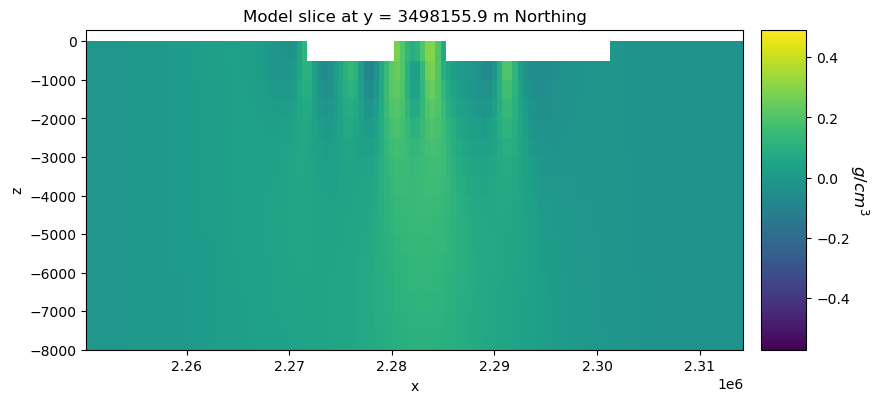

In [135]:
# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
mesh.plot_slice(
    plotting_map * recovered_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    clim=(np.min(recovered_model), np.max(recovered_model)),
    pcolor_opts={"cmap": "viridis"},
)
# ax1.scatter(grav_east, meas_height, c='k', zorder=3) # this is not quite correct yet, need to choose the slice of the grid
ax1.set_ybound(-8000,300)
ax1.set_title(f"Model slice at y = {center_meas_y:.1f} m Northing")
ax1.set_xlabel('x')

ax2 = fig.add_axes([0.85, 0.1, 0.05, 0.8])
norm = mpl.colors.Normalize(vmin=np.min(recovered_model), vmax=np.max(recovered_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()

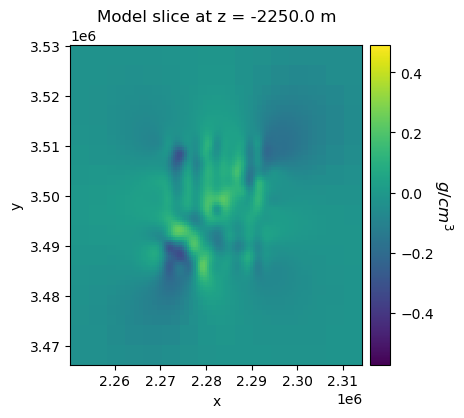

In [138]:
# Plot Recovered Model
fig = plt.figure(figsize=(4, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
mesh.plot_slice(
    plotting_map * recovered_model,
    normal="Z",
    ax=ax1,
    ind=27,
    grid=False,
    clim=(np.min(recovered_model), np.max(recovered_model)),
    pcolor_opts={"cmap": "viridis"},
)
ax1.set_title(f"Model slice at z = {mesh.cell_centers_z[27]} m")
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2 = fig.add_axes([0.85, 0.1, 0.05, 0.8])
norm = mpl.colors.Normalize(vmin=np.min(recovered_model), vmax=np.max(recovered_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()

Plot predicted and observed data

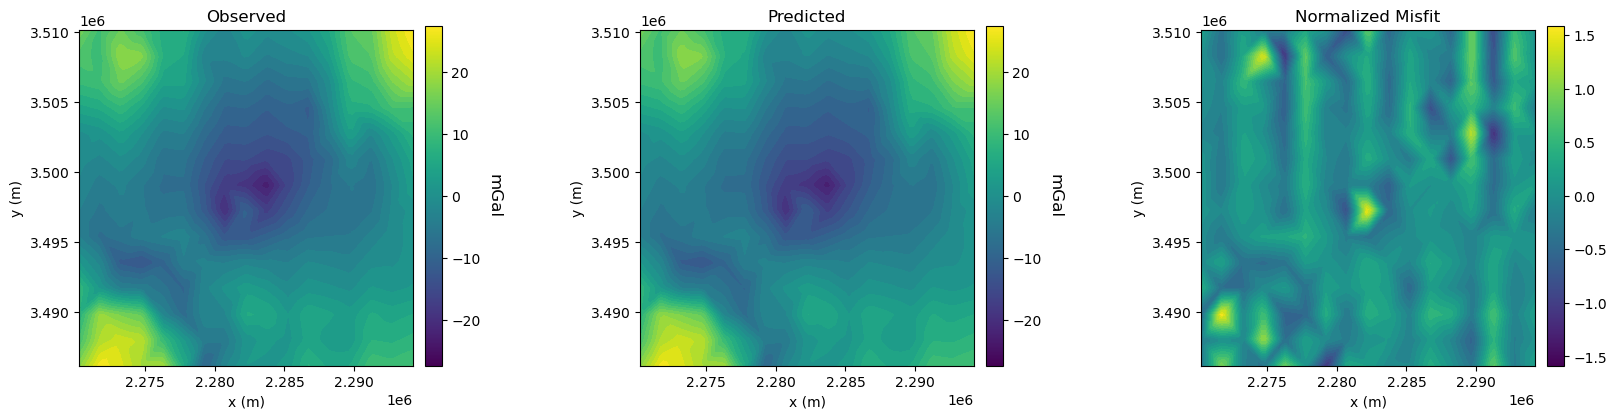

In [ ]:
# Predicted data with final recovered model
dpred = inv_prob.dpred

# Observed data | Predicted data | Normalized data misfit
data_array = np.c_[dobs, dpred, (dobs - dpred) / uncertainties]

fig = plt.figure(figsize=(17, 4))
plot_title = ["Observed", "Predicted", "Normalized Misfit"]
plot_units = ["mGal", "mGal", ""]

ax1 = 3 * [None]
ax2 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]
v_lim = [np.max(np.abs(dobs)), np.max(np.abs(dobs)), np.max(np.abs(data_array[:, 2]))]


for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.33 * ii + 0.03, 0.11, 0.23, 0.84])
    cplot[ii] = plot2Ddata(
        receiver_list[0].locations,
        data_array[:n_data:, ii],
        ax=ax1[ii],
        ncontour=30,
        clim=(-v_lim[ii], v_lim[ii]),
        contourOpts={"cmap": "viridis"},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("x (m)")
    ax1[ii].set_ylabel("y (m)")

    ax2[ii] = fig.add_axes([0.33 * ii + 0.25, 0.11, 0.01, 0.85])
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="vertical", cmap='viridis'
    )
    cbar[ii].set_label(plot_units[ii], rotation=270, labelpad=15, size=12)

plt.show()